# Different Strides

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os

from torch.utils.data import DataLoader
from data.image_dataset import ImageDataset
from torchvision.transforms import v2
from torchvision.models import inception_v3
from models.convnet import ConvNet
from models.nvgaze import NVGaze
from models.incep_convnet import IncepConvNet
from training.train import *
from training.eval import *
from data.convert_labels import *
from utils.dataset_utils import check_disjoint
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
for stride in [2, 5, 10, 20, 40]:
  subject = 1
  input_dims = (1, 120, 160) # (C, H, W)
  note = ''
  mode = 'reg'
  batch_size = 64

  data_subset = f'{subject:>02}_{stride:>02}_{input_dims[2]}_{input_dims[1]}{f'_{note}' if note else ''}'
  train_dir_path = f'data/real/{data_subset}/train'
  train_annotations_file_path = f'{train_dir_path}/{data_subset}_train.csv'
  val_dir_path = f'data/real/{data_subset}/val'
  val_annotations_file_path = f'{val_dir_path}/{data_subset}_val.csv'
  test_dir_path = f'data/real/{data_subset}/test'
  test_annotations_file_path = f'{test_dir_path}/{data_subset}_test.csv'

  target_transform = None

  train_dataset = ImageDataset(
    annotations_file=train_annotations_file_path,
    img_dir=train_dir_path,
    transform=None,
    target_transform=target_transform
  )
  val_dataset = ImageDataset(
    annotations_file=val_annotations_file_path,
    img_dir=val_dir_path,
    transform=None,
    target_transform=target_transform
  )
  test_dataset = ImageDataset(
    annotations_file=test_annotations_file_path,
    img_dir=test_dir_path,
    transform=None,
    target_transform=target_transform
  )

  # assert(check_disjoint(val_dataset, test_dataset))

  # Create Dataloader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  out_num_features = 2

  model = NVGaze(input_dims, out_num_features, dropout_param=0.05)

  criterion = nn.MSELoss() if mode == 'reg' else nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 180], gamma=0.01)

  # Set-up GPU device (if available) and move model
  device = torch.device('mps' if torch.mps.is_available else 'cpu')
  model = model.to(device)
  print(f'Using device: {device}')

  results = train(model, device, mode, criterion, optimizer, train_loader, val_loader, epochs=200)

  train_error = evaluate_error(model, device, train_loader)
  val_error = evaluate_error(model, device, val_loader)
  test_error = evaluate_error(model, device, test_loader)
  train_error_str = f'Train err: {train_error.item():.6f} ({np.rad2deg(train_error.item()):.2f}°)'
  val_error_str = f'Val err:   {val_error.item():.6f} ({np.rad2deg(val_error.item()):.2f}°)'
  test_error_str = f'Test err:  {test_error.item():.6f} ({np.rad2deg(test_error.item()):.2f}°)'
  error_summary = [train_error_str, val_error_str, test_error_str]
  error_summary_str = '\n'.join(error_summary)
  print(f'{stride:>02}')
  print(error_summary_str)
  print()

Using device: mps
02
Train err: 0.022642 (1.30°)
Val err:   0.066905 (3.83°)
Test err:  0.080652 (4.62°)

Using device: mps
05
Train err: 0.024780 (1.42°)
Val err:   0.067525 (3.87°)
Test err:  0.067484 (3.87°)

Using device: mps
10
Train err: 0.045805 (2.62°)
Val err:   0.086793 (4.97°)
Test err:  0.094881 (5.44°)

Using device: mps
20
Train err: 0.034163 (1.96°)
Val err:   0.057779 (3.31°)
Test err:  0.113387 (6.50°)

Using device: mps
40
Train err: 0.036788 (2.11°)
Val err:   0.063208 (3.62°)
Test err:  0.066823 (3.83°)



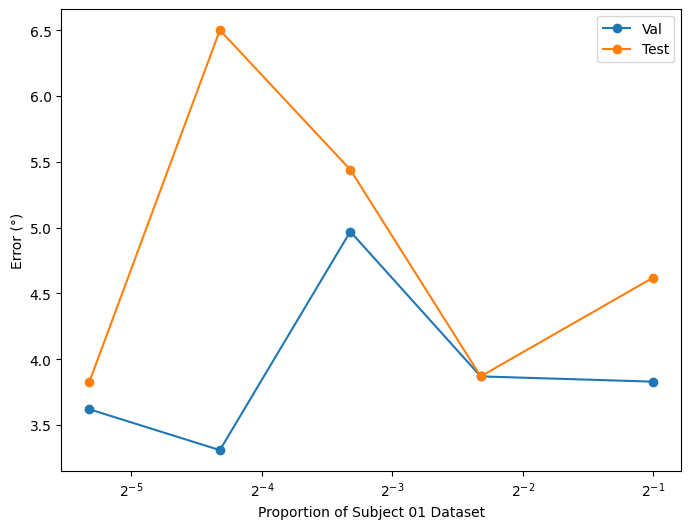

In [11]:
proportion = [0.5, 0.2, 0.1, 0.05, 0.025]
val_history = [3.83, 3.87, 4.97, 3.31, 3.62]
test_history = [4.62, 3.87, 5.44, 6.50, 3.83]

plt.plot(proportion, val_history, '-o')
plt.plot(proportion, test_history, '-o')
plt.xscale('log', base=2)
plt.legend(['Val', 'Test'], loc='upper right')
plt.xlabel('Proportion of Subject 01 Dataset')
plt.ylabel('Error (°)')

fig = plt.gcf()
plt.show()